# Traffic Sign Classification

## Imports

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg

## Data Exploration
First lets see how balanced our dataset is by checking the number of images in each class. (Note many images does not necessarily mean balanced as they may all be similar - for example if we were identifing cats vs dogs but we only had pictures of orange cats we would have serious bias regardless of how many pictures of orange cats we have)

In [2]:
# get class names
class_path = '../input/traffic-sign-dataset-classification/labels.csv'
classes = pd.read_csv(class_path)
class_names = list(classes['Name'])
print(class_names)

['Speed limit (5km/h)', 'Speed limit (15km/h)', 'Speed limit (30km/h)', 'Speed limit (40km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'speed limit (80km/h)', 'Dont Go straight or left', 'Dont Go straight or Right', 'Dont Go straight', 'Dont Go Left', 'Dont Go Left or Right', 'Dont Go Right', 'Dont overtake from Left', 'No Uturn', 'No Car', 'No horn', 'Speed limit (40km/h)', 'Speed limit (50km/h)', 'Go straight or right', 'Go straight', 'Go Left', 'Go Left or right', 'Go Right', 'keep Left', 'keep Right', 'Roundabout mandatory', 'watch out for cars', 'Horn', 'Bicycles crossing', 'Uturn', 'Road Divider', 'Traffic signals', 'Danger Ahead', 'Zebra Crossing', 'Bicycles crossing', 'Children crossing', 'Dangerous curve to the left', 'Dangerous curve to the right', 'Unknown1', 'Unknown2', 'Unknown3', 'Go right or straight', 'Go left or straight', 'Unknown4', 'ZigZag Curve', 'Train Crossing', 'Under Construction', 'Unknown5', 'Fences', 'Heavy Vehicle Accidents'

In [3]:
data_dir = '../input/traffic-sign-dataset-classification/traffic_Data/DATA'
num_images = pd.DataFrame(class_names, columns=['label'])

In [4]:
count = []
for dir in os.listdir(data_dir):
    count.append(len(os.listdir(data_dir + '/' + dir)))
num_images['count'] = count
num_images.head()

,label,count
0,Speed limit (5km/h),152
1,Speed limit (15km/h),12
2,Speed limit (30km/h),130
3,Speed limit (40km/h),4
4,Speed limit (50km/h),18


In [5]:
num_images.label.value_counts()

Bicycles crossing               2
Speed limit (40km/h)            2
Speed limit (50km/h)            2
Go left or straight             1
Road Divider                    1
Traffic signals                 1
Danger Ahead                    1
Zebra Crossing                  1
Children crossing               1
Dangerous curve to the left     1
Dangerous curve to the right    1
Unknown1                        1
Unknown2                        1
Unknown3                        1
Go right or straight            1
Speed limit (5km/h)             1
Unknown4                        1
Uturn                           1
Train Crossing                  1
Under Construction              1
Unknown5                        1
Fences                          1
Heavy Vehicle Accidents         1
Unknown6                        1
Give Way                        1
No stopping                     1
No entry                        1
Unknown7                        1
ZigZag Curve                    1
Horn          

It looks like some directories are in there twice... let's look into this.

<Figure size 432x288 with 0 Axes>

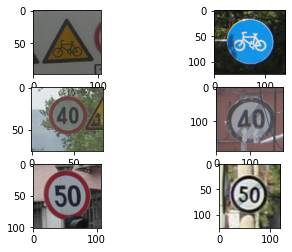

In [6]:
plt.figure()
fig, axs = plt.subplots(3, 2)
img = mpimg.imread('../input/traffic-sign-dataset-classification/traffic_Data/DATA/36/036_0001.png')
axs[0,0].imshow(img)
img = mpimg.imread('../input/traffic-sign-dataset-classification/traffic_Data/DATA/30/030_0001.png')
axs[0,1].imshow(img)
img = mpimg.imread('../input/traffic-sign-dataset-classification/traffic_Data/DATA/3/003_0001.png')
axs[1,0].imshow(img)
img = mpimg.imread('../input/traffic-sign-dataset-classification/traffic_Data/DATA/18/018_0001.png')
axs[1,1].imshow(img)
img = mpimg.imread('../input/traffic-sign-dataset-classification/traffic_Data/DATA/4/004_0001.png')
axs[2,0].imshow(img)
img = mpimg.imread('../input/traffic-sign-dataset-classification/traffic_Data/DATA/19/019_0001.png')
axs[2,1].imshow(img)

plt.show()

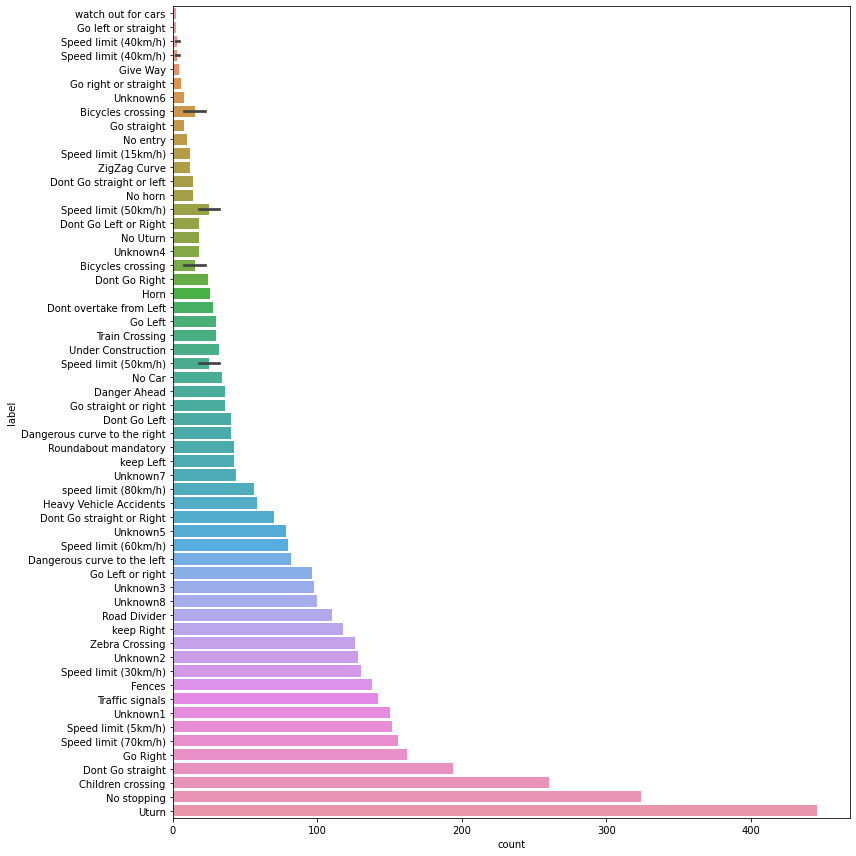

In [7]:
# plot graph
plt.figure(figsize=(12, 12))
sns.barplot(data=num_images, x=num_images["count"], y="label", order=num_images.sort_values("count").label)
plt.tight_layout()

In [8]:
num_images.sort_values('count')[:10]

,label,count
28,watch out for cars,2
44,Go left or straight,2
18,Speed limit (40km/h),2
3,Speed limit (40km/h),4
53,Give Way,4
43,Go right or straight,6
52,Unknown6,8
30,Bicycles crossing,8
21,Go straight,8
55,No entry,10


These categories do not have very many examples - we'll have to check them at the end using a confusion matrix.

## Creating the data pipeline

Here we will use the ImageDataGenerator class from the keras libarary to feed the images into the neural network, and to scale the images automatically. The advantage of this is images can be loaded in batches as they are needed, rather than having to download and store each image. We are also able to randomly augment the training images if needed as they are fed into the network, again meaning we don't need to create and save extra augmented images.

First we will create an instance of ImageDataGenerator. 
* rescale = 1.0/255 (RGB values will be between 0 and 255, but the network will favour higher values so it's important to rescale)
* setting validation_split will allow us to separate out training and test data without data leakage

In [9]:
datagen = ImageDataGenerator(rescale = 1.0/255, validation_split=0.5)

Next we will create the iterators for pulling images from the data directory.
Target_size defaults to (256, 256) and batch_size defaults to 32 which is good for now. If we want to speed up the model we could play with different target_sizes as we may not need all 256x256 pixels to create a good model but for now this is fine. 

In [10]:
BATCH_SIZE = 32
train_gen = datagen.flow_from_directory(data_dir, class_mode='categorical', subset='training', batch_size=BATCH_SIZE)
test_gen = datagen.flow_from_directory(data_dir, class_mode='categorical', subset='validation', batch_size=BATCH_SIZE, shuffle=False)

Found 2085 images belonging to 58 classes.
Found 2085 images belonging to 58 classes.


In [11]:
# Get number of images to calc steps per epoch later
train_images = train_gen.samples
test_images = test_gen.samples

In [12]:
# check iterators are working
batchX, batchY = train_gen.next()
print('train batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))
batchX, batchY = test_gen.next()
print('test batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))
input_shape = batchX.shape[1:]

train batch shape=(32, 256, 256, 3), min=0.000, max=1.000
test batch shape=(32, 256, 256, 3), min=0.000, max=1.000


## Creatin the model with transfer learning

Rather than creating our own convolutional base we will instead use a pretrained one that has been trained on many many more images than we have available.
We will then add our dense layers and output layer.

Let's try the Xceptron model. 

In [13]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping

We need to set trainable = False so that the base weights do not change. This saves a lot of time as it significantly reduces the amount of parameters the model has to tune, also the weights have already been optimised. 
In some cases it makes sense to let the weights be tuned, or to let the last few layers of the base be tuned. But for now we'll keep it simple and leave them as is.

In [14]:
pretrained_base=Xception(include_top=False, input_shape = input_shape, pooling='avg', weights="imagenet")
pretrained_base.trainable=False
model = Sequential(
    [
    pretrained_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.1),
    Dense(len(class_names), activation='softmax')
    ]
)

83697664/83683744 [==============================] - 0s 0us/step


In [15]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 58)                14906     
Total params: 21,400,930
Trainable params: 539,450
Non-trainable params: 20,861,480
_________________________________________________________________
None


## Compiling and training the model

In [16]:
model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

Creating callback for early stopping is validation loss does not improve, and to restore best weights

In [17]:
callback= EarlyStopping(
  monitor="val_loss",
  min_delta=0.001,
  patience=5,
  restore_best_weights=True)

In [18]:
hist = model.fit_generator(steps_per_epoch=train_images/BATCH_SIZE, generator=train_gen, validation_data= test_gen, 
                           validation_steps=test_images/BATCH_SIZE, epochs=5, callbacks=[callback])

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
65/65 [==============================] - 33s 366ms/step - loss: 2.0216 - accuracy: 0.5415 - val_loss: 0.9274 - val_accuracy: 0.7703
Epoch 2/5
65/65 [==============================] - 13s 206ms/step - loss: 0.7420 - accuracy: 0.8240 - val_loss: 0.4140 - val_accuracy: 0.9151
Epoch 3/5
65/65 [==============================] - 14s 220ms/step - loss: 0.4218 - accuracy: 0.9084 - val_loss: 0.2531 - val_accuracy: 0.9549
Epoch 4/5
65/65 [==============================] - 13s 204ms/step - loss: 0.2499 - accuracy: 0.9472 - val_loss: 0.1573 - val_accuracy: 0.9712
Epoch 5/5
65/65 [==============================] - 13s 206ms/step - loss: 0.1786 - accuracy: 0.9612 - val_loss: 0.0977 - val_accuracy: 0.9899


In [19]:
# Save the model
model.save('traffic_signal_model_final.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


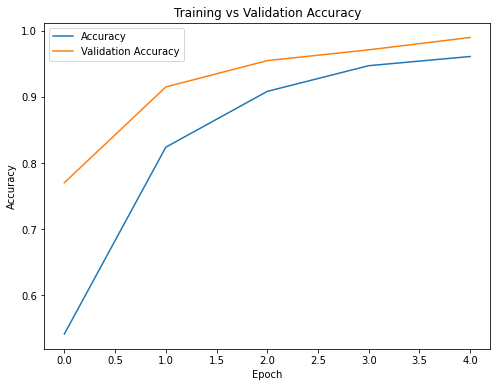

In [20]:
# plot results
plt.figure(figsize=(8, 6))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend(["Accuracy","Validation Accuracy"])

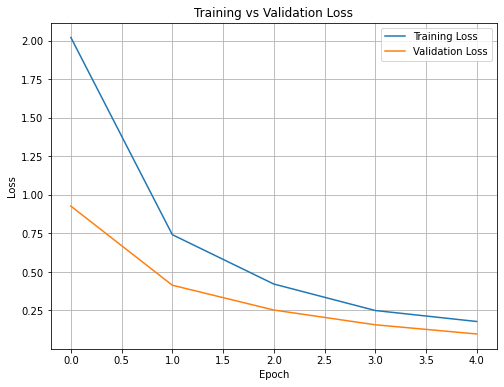

In [21]:
# Plot Loss
plt.figure(figsize=(8, 6))
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

The model has very good performance! Interestingly the validation accuracy is higher than the training accuracy for most epochs. This can happen because of dropout - the validation accuracy has access to the whole network whilst the training accuracy does not. 

## Evaluating the CNN

So we got super good performance on validation accuracy but let's take a closer look at the model.
To evaluate the CNN we will look at:

* precision - what proportion of 'positives' are truely positive?

$$ \text{precision} = \frac{\text{true positives}} {\text{true positives + false positives}} $$

* recall - what proportion of actual 'positives' are correctly classified?

$$ \text{recall} = \frac{\text{true positives}} {\text{true positives + false negatives}} $$

* accuracy - what proportion of images were correctly classified?

$$ \text{accuracy} = \frac{\text{true positives + true negatives}} {\text{true positives + true negatives + false positives + false negatives}} $$

* f1_score - harmonic mean between precision and recall

$$ \text{f1_score} = \frac{2 \times \text{precision} \times \text{recall}} {\text{precision + recall}} $$

We will use classification report to generate a summary of the above values for each class and also a confusion_matrix to show predictions vs true results

In [22]:
from sklearn.metrics import classification_report, confusion_matrix


Step 1 is generating our predictions

In [23]:
test_gen.reset()
raw_predictions = model.predict(test_gen)

Each of the predictions is an array containing the likelihood of the image being in each class, to get the actual classification we simply take the index of the higest (most likely) value.

In [24]:
predictions = []
for item in raw_predictions:
    predictions.append(np.argmax(item))

In [25]:
print(classification_report(test_gen.labels, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        59
           1       1.00      0.90      0.95        20
           2       1.00      1.00      1.00        35
           3       1.00      0.99      0.99        69
           4       1.00      1.00      1.00        48
           5       1.00      0.94      0.97        18
           6       1.00      1.00      1.00        64
           7       1.00      1.00      1.00        11
           8       1.00      1.00      1.00        71
           9       1.00      1.00      1.00        65
          10       1.00      1.00      1.00         4
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00        40
          13       1.00      0.89      0.94         9
          14       1.00      1.00      1.00         6
          15       1.00      1.00      1.00         9
          16       1.00      1.00      1.00         7
          17       1.00    

So to two significant figs it looks the model is basically performing perfectly.

Let's also create a confusion matrix to see what the model predicted for each class

In [26]:
cm = confusion_matrix(test_gen.labels, predictions)

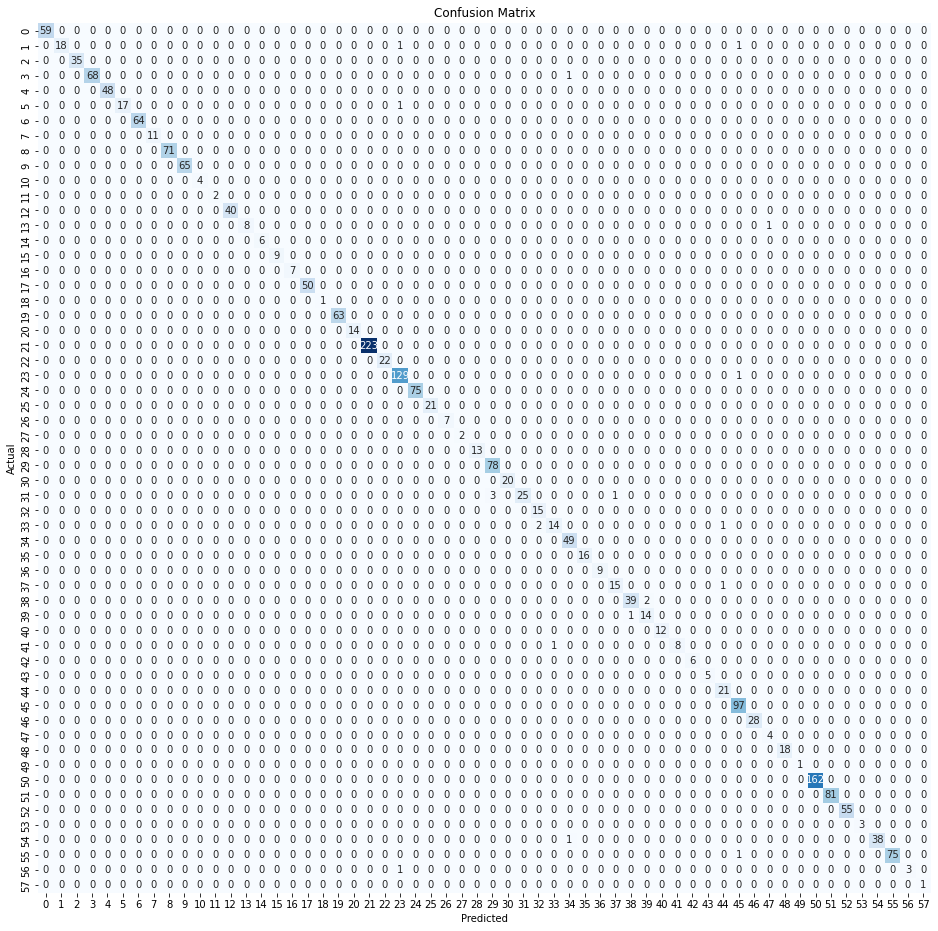

In [27]:
plt.figure(figsize=(16, 16))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

The model has performed extremely well - no incorrect predictions!